In [1]:
import dataretrieval.nwis as nwis
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from create_river_roms import *

# Details about river forcing files

We use the [`dataretrieval-python`](https://doi-usgs.github.io/dataretrieval-python) package to access USGS NWIS river data.

## Background information

There is a [report](https://tidesandcurrents.noaa.gov/ofs/publications/CS_Techrpt_040_SA_CIOFS_2020.pdf) from the Coast Survey Development Laboratory modeling group's development of the CIOFS model, and this along with two nowcast rivers forcing files we received from the NOAA OFS modeling group is what we used to create our own river forcing files, trying to follow the same logic when possible.

Freshwater is included in the CIOFS model as 12 rivers spread over 36 river points. The rivers included are listed in the left column here:


Number | River Station in Model | USGS Station Used: Discharge | USGS Station Used: Water temp | Notes
------ | ---------------------- | ----------------- | ---------------------------- | -----
1      | 15295700: <br> Terror River at mouth near Kodiak, AK | 15295700 | 15295700 | 
2      | 15239070: <br> Bradley River near Tidewater near Homer, AK | 15239070 | 15239070 |
3      | 15239900: <br> Anchor River near Anchor Point, AK | 15239900 | 15239900
4      | 15266300: <br> Kenai River at Soldotna, AK | 15266300 | 15266300 | 
5      | 15271000: <br> Sixmile Creek near Hope, AK | 15271000 | 15258000: <br> Kenai River at Cooper Landing AK | 
6      | 15274600: <br> Campbell Creek near Spendard, AK | 15274600 | 15276000: <br> Ship Canal near Anchorage AK
7      | 15275100: <br> Chester Canal at Arctic Boulevard at Anchorage, AK | 15275100 | 15276000: <br> Ship Canal near Anchorage AK |
8      | 15276000: <br> Ship Canal near Anchorage, AK | 15276000 | 15276000 | 
9      | 15281000: <br> Knik River near Palmer, AK | 15281000 | 15284000: <br> Matanuska River near Palmer, AK | 
10     | 15284000: <br> Matanuska River near Palmer, AK | 15284000 | 15284000 |
11     | 15290000: <br> Little Susitna River near Palmer, AK | 15290000 | 15290000 | 
12     | 15292780: <br> Susitna River at Sunshine, AK | 15292000: <br> Susitna River at Gold Creek AK | 15292780 | Discharge from 15292000 is multiplied by 2.

River input locations are shown on this map from the development report:

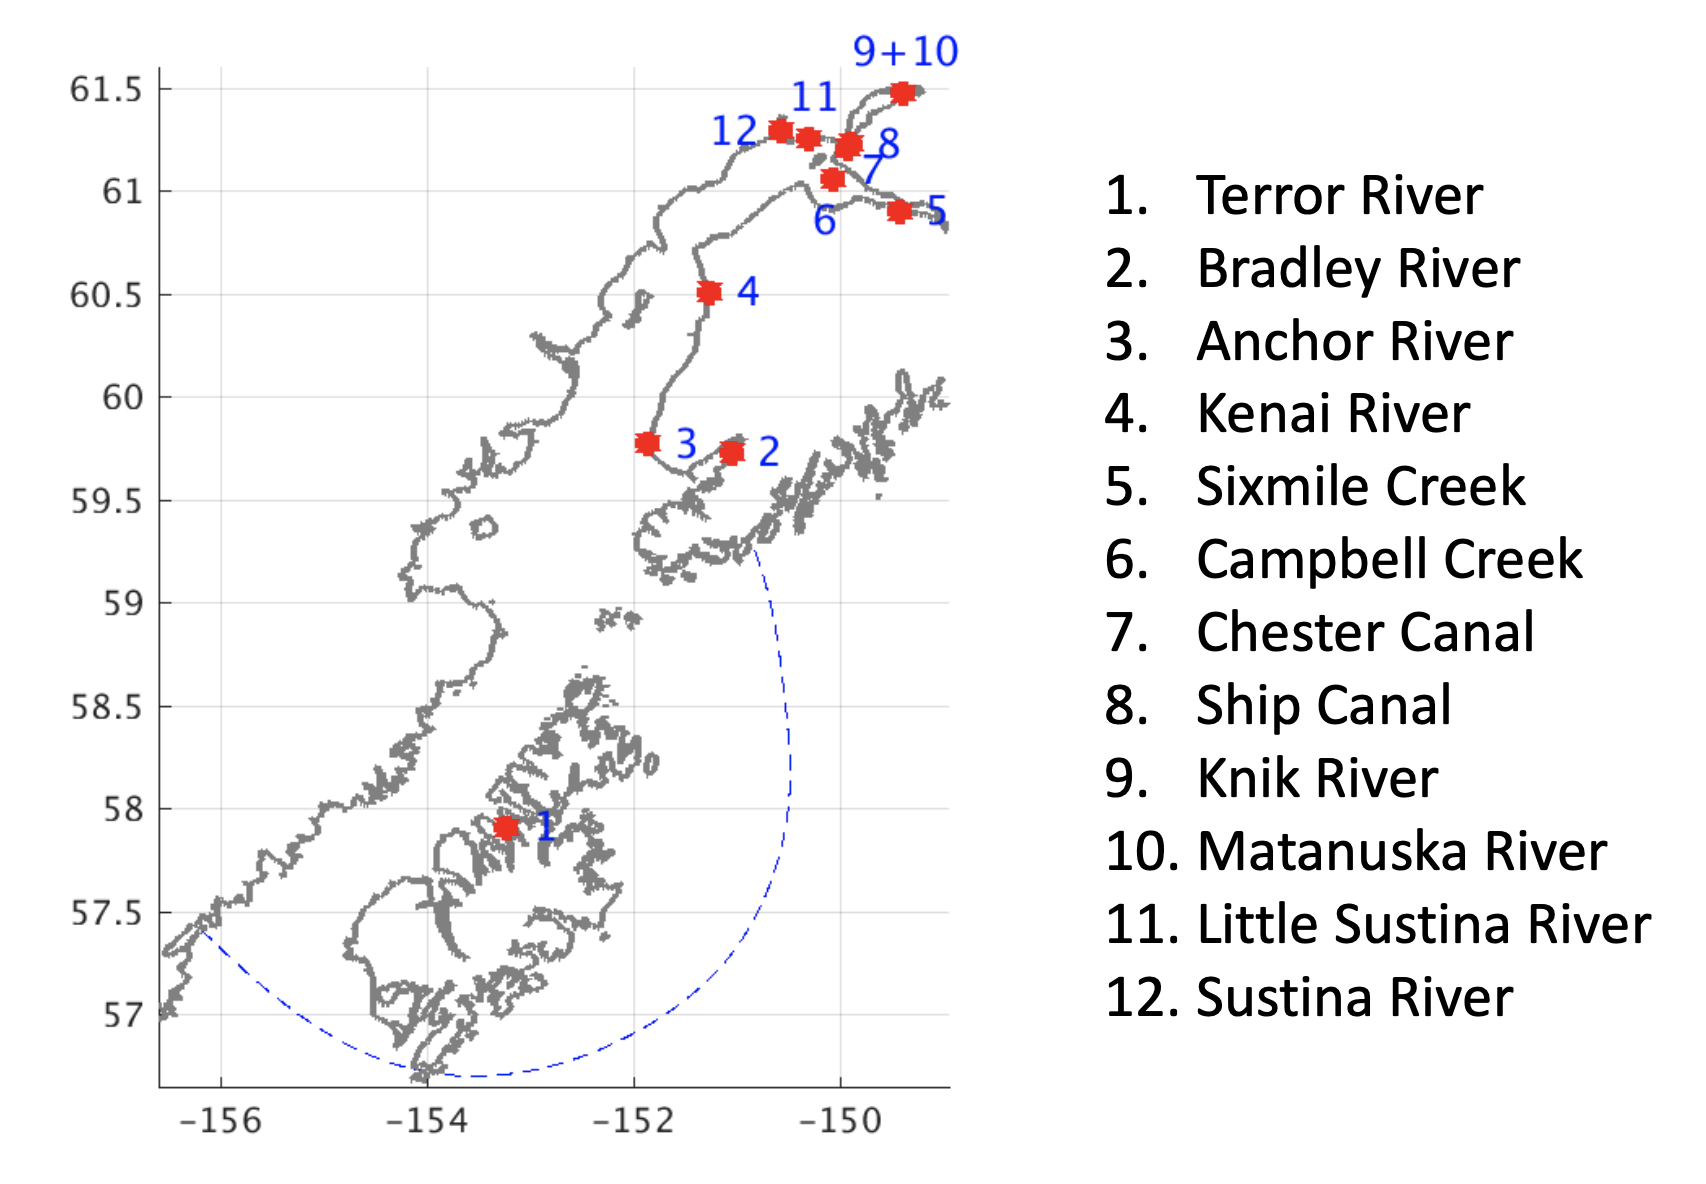

INCLUDE PLOTS FROM REPORT

## General approach

Here is a text flow chart of the logic in `create_river_roms.py`. Logic flows first down, then across a line and stops if "Done", otherwise continues down the list.

Discharge:

1. get discharge data.
1. Check for:
    1. empty → check gage data
    1. fully present (all time stamps for date range) with good data flags (“A” or “P” flag) → use, done.
    1. Reindex to fill all missing times with nans
    1. Deal with other flags
        1. Any questionable flags present (“A, e”, “P, e”)?
        1. Is there good (“A” or “P”) gage data during the time period of the questionable flags?
            1. no? keep questionable data.
            1. yes? fill questionable flag data values with nan.
        1. Any bad flags present? (“P, Ice”, “P, Eqp”, “A, Ice”, “A, Eqp” - not sure if the A ones ever happen)
            1. fill bad flags data with nan
    1. Check gap lengths.
1. Has gaps in data. Process all gaps. If gaps are:
    1. Less than 8 days → interpolate
    1. Over 8 days → check gage data



1. Get gage data. 
1. Check for:
    1. rating curve data empty or gage data empty → use mean. Done.
    1. fully present with good data flags → estimate with gage data. Done.
    1. Reindex to fill all missing times with nans
    1. Deal with other flags.
        1. Fill ice flag data with 0s.
        1. Fill eqp flag data with nans (to be filled in as gaps).
    1. Estimate discharge from gage data time series
    1. Check gap lengths
1. Has gaps in data. Gaps are:
    1. Less than 8 days → interpolate
    1. Over 8 days → use mean data


Water temperature:

1. get temp data.
1. Check for:
    1. empty → use mean data. Done.
    1. fully present (all time stamps for date range) with good data flags (“A” or “P” flag) → use, done.
    1. Reindex to fill all missing times with nans
    1. Check gap lengths.
1. Has gaps in data. Process all gaps. If gaps are:
    1. Less than 8 days → interpolate
    1. Over 8 days → use mean data

## Other details

We followed what we saw in two river forcing files from the CIOFS group, and ascertained some details to include in the data processing:

* River salinity is set to 0.005 for all rivers
* River temperature is never allowed to be below 1 degree Celsius.
* Use all data in UTC.


We also purposely have some differences between out approach and NOAA's:
* In the REPORT it was stated that the temperatures from Bradley River (Station WHAT) were used for all stations.

What stations are used for other stations, maybe with factor of 2.



### Discharge for Station 15292780

The NOAA Report states that they used Station 15292000 discharge multiplied by 2 to replace discharge from Station 15292780 since Station 15292780 has a relatively short lifespan. We do the same in our simulations. Here is the comparison of the daily means for these two time series, including the multiplication factor. The match is reasonable.

Text(0, 0.5, 'River discharge [m$^3$/s]')

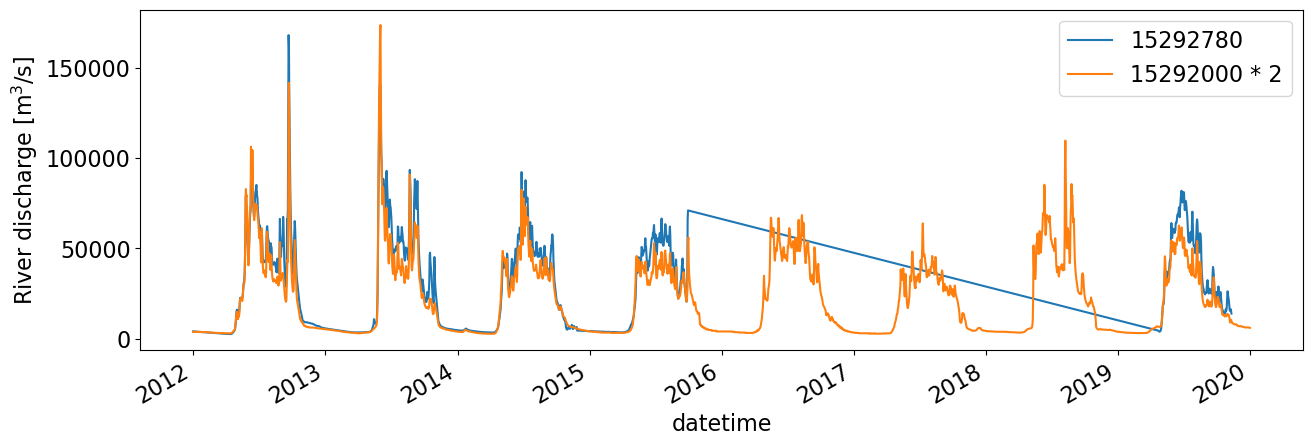

In [13]:
station = "15292780"
start = "2012-1-1"
end = "2020-12-31"
df1 = nwis.get_record(sites=station, service='dv', start=start, end=end)
station = "15292000"
df2 = nwis.get_record(sites=station, service='dv', start=start, end=end)
ax = df1["00060_Mean"].loc[:"2019"].plot(figsize=(15,5), label="15292780")
(df2["00060_Mean"]*2).loc[:"2019"].plot(ax=ax, label="15292000 * 2")
plt.legend()
plt.ylabel("River discharge [m$^3$/s]")

### Geographic variation of water temperature

The development report states that Bradley River (15239070) was used to represent all rivers in the model. We chose to allow for spatially-varying data. This one year of data shows an example of the variation in temperature data across the region. There is a fair amount of variation, but we have run no tests to analyze how impactful the variation is for the final results.

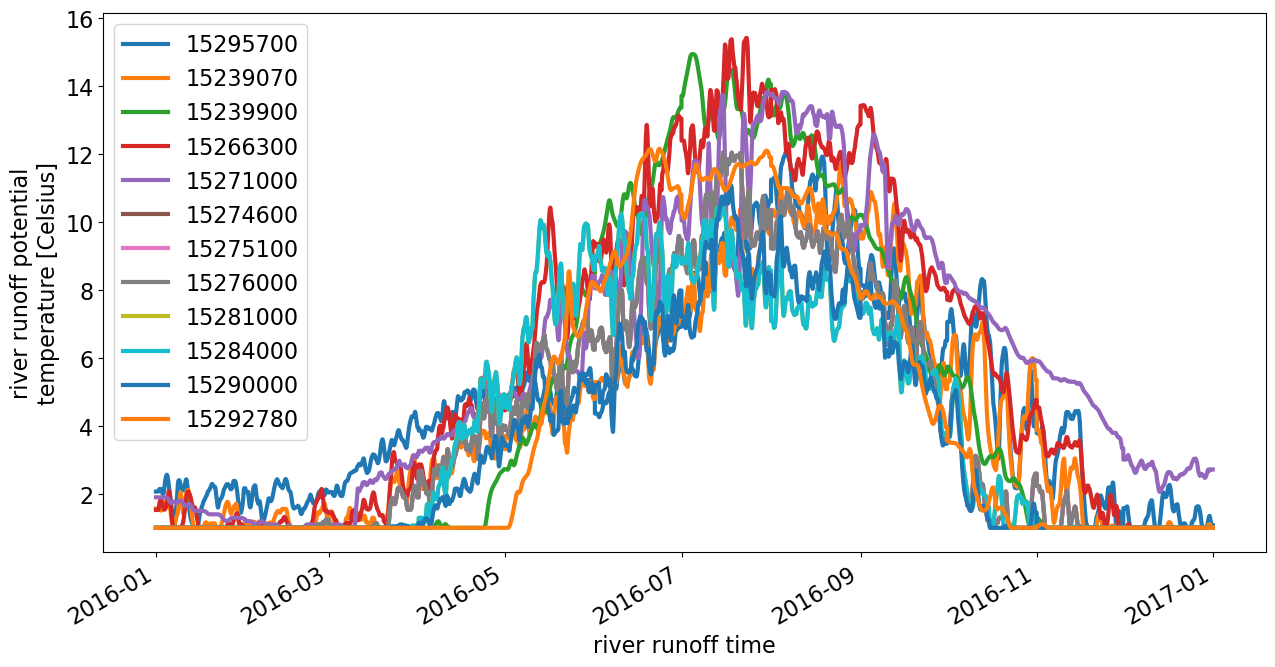

In [13]:
year = 2016
base = "output/river"
locs = f"{base}/axiom.ciofs.river.{year}*.nc"
ds = xr.open_mfdataset(locs, concat_dim="time", combine='nested')
ds = ds.swap_dims({"time": "river_time"})

unique_inds = list(set([station_list_file.index(station_list_file[i]) for i in range(nrivers)]))
labels = [station_list_file[i] for i in unique_inds]
ds["river_temp"].isel(s_rho=0, river=unique_inds).plot.line(x="river_time", lw=3, figsize=(15,7));
plt.legend(labels)

### Rolling mean of gage data

We include a rolling mean over 24 hours of gage data because it can be jumpy sometimes. This is in addition to a final rolling mean of the resulting discharge and temperature data. As an example as to this effect, we show gage data from Station "15276000" in December 2010 before and after applying a rolling mean.

Text(0.5, 1.0, 'Station 15276000')

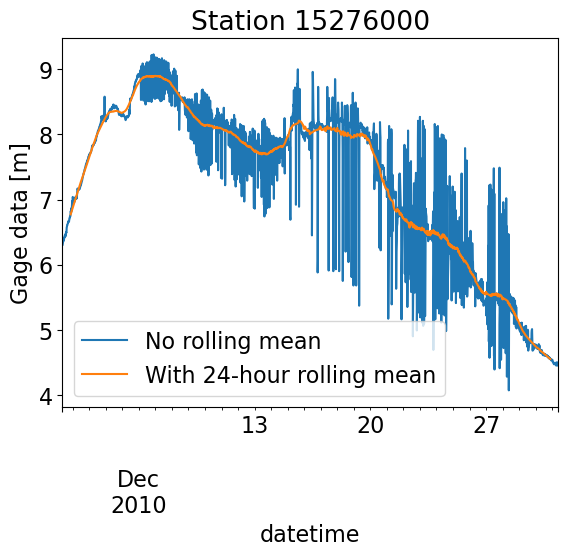

In [21]:
start, end = "2010-12-1T00:00", "2010-12-31T00:00"
station = "15276000"
df = return_nwis_data(station, "00065", start, end)
df["00065"].plot(label="No rolling mean")
# this data is every 15 minutes
df["00065"].rolling(center=True, window=24*4).mean().plot(label="With 24-hour rolling mean")
plt.legend()
plt.ylabel('Gage data [m]')
plt.title("Station 15276000")

### Demonstrate using the rating curve

When discharge data is not available or is flagged as an "estimate", real-time gage data will be used if available. As described by the [USGS](https://www.usgs.gov/faqs/how-rating-curve-used-convert-gage-height-streamflow), the rating curve gives an empirical relationship between gage height and discharge in the form of a table. We use this data, when available, to convert gage data to a discharge estimate. If necessary, we extrapolate the rating curve up or down with a third-order polynomial to match the gage data, but we [cap it at twice the highest measured discharge](https://kacv.net/brad/nws/lesson7.html) and do not allow negative discharge.

Here is an example which shows the rating curve for Station 15295700 as well as an extrapolation up and down to higher and lower gage values.

Text(0, 0.5, 'Discharge [ft$^3$/s]')

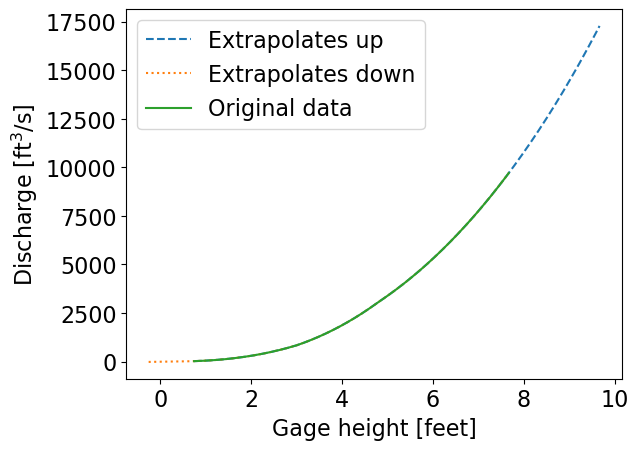

In [26]:
ratingDataOrig = nwis.get_ratings(site="15295700", file_type="exsa")[0]
ratingDataHigher = extrapolate_rating_curve(ratingDataOrig, ratingDataOrig["INDEP"].max() + 2, "up")
ratingDataLower = extrapolate_rating_curve(ratingDataOrig, ratingDataOrig["INDEP"].min() -1, "down")

ax = ratingDataHigher.plot(x="INDEP", y="DEP", label="Extrapolates up", ls="--")
ratingDataLower.plot(x="INDEP", y="DEP", ax=ax, label="Extrapolates down", ls=":")
ratingDataOrig.plot(x="INDEP", y="DEP", ax=ax, label="Original data")
ax.set_xlabel("Gage height [feet]")
ax.set_ylabel("Discharge [ft$^3$/s]")

### Mean time series

Text(0.5, 1.0, 'Mean time series for Station 15266300')

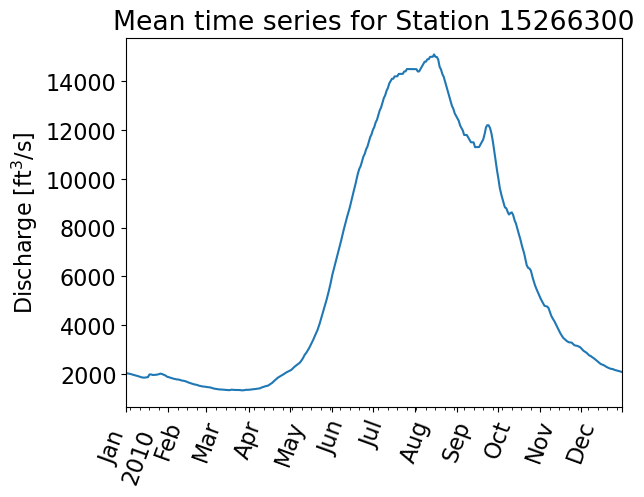

In [33]:
station = "15266300"
# start and end are for returning the desired window of values, not for computing the mean time series
start, end = "2010-1-1T00:00", "2010-12-31T00:00"
df = find_mean_time_series(station, start, end, "00060")
df.plot(rot=70)
plt.ylabel("Discharge [ft$^3$/s]")
plt.title(f"Mean time series for Station {station}")

You impact of substituting the mean time series data in for the discharge when needed is that there could be a jump between the two signals. We simply perform a 12 hour rolling mean on the discharge signal at the end of processing in order to improve this, but it is a small measure; there will still be some unrealistic jumps in the river signals. However, we think it is worth it to have more freshwater entering the model domain when we know it is present and important to the region.

Text(0.5, 1.0, 'Estimated discharge for Station 15266300')

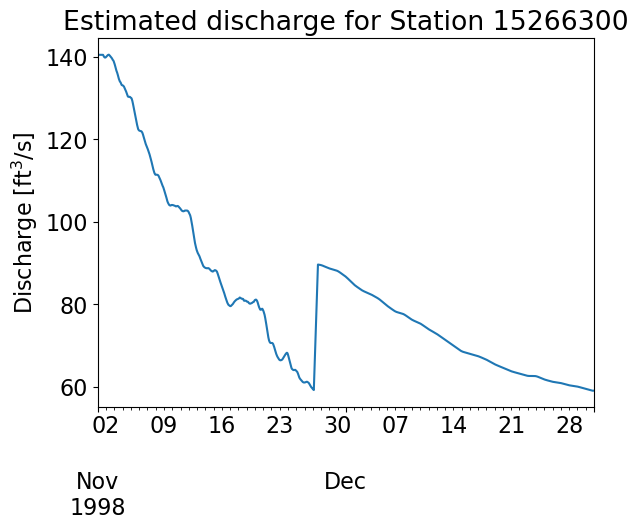

In [35]:
start, end = "1998-11-01T00:00", "1998-12-31T00:00"
station = "15266300"
df = find_discharge(station, start, end, ndays=8)
df.plot()
plt.ylabel("Discharge [ft$^3$/s]")
plt.title(f"Estimated discharge for Station {station}")

## Comparing Axiom and NOAA versions of two river forcing files

We received two example nowcast river forcing files which we recreate here as a comparison with our methods. Note that in order to compare with the four-day nowcast files we do two things differently from our month-long hindcast forcing files:
1. interpolate under 2 days and use gage or mean time series data over 2 days instead of 8 days for both
1. do not apply a rolling mean of 12 hours

The main differences seen below are:
1. We estimate discharge if gage data is available and discharge data is unavaiable or unreliable, and if gage data isn't available but the instrument is not flagged as "iced", then we include discharge from the statistical mean time series for the station. Because of this, we include much more freshwater input as compared with the example files. NOAA's file does include an estimate of discharge from gage data from one river, but not from other rivers. Perhaps when running operationally, it is not always possible to estimate the discharge using gage data
1. We used geographically-varying water temperature data, whereas the NOAA groups use data only from Bradley River (Station 15239070). When real-time water temperature data is not available, we use the statistical mean time series for the station. When a station has never had an instrument to measure water data, we have a replacement station as shown in the station table.
1. The nowcast forcing files are created by NOAA at the mid point of the time series such that they use the real-time data up until the start of the simulation, and the second half of the forcing is a simple linear extrapolation of the available data (which is why they appear as straight lines for those times).

In [9]:
def plot_comparison(ds, dscompare):
    
    plt.rc('font', size=16)
    
    color_noaa = "cornflowerblue"
    color_axiom = "hotpink"
    kwargs_line = {"x": "river_time", "lw": 3}
    kwargs_noaa = {"color": color_noaa, "label": "NOAA"}
    kwargs_axiom = {"color": color_axiom, "label": "Axiom", "ls": "--"}
    
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    ds["river_transport"].plot(ax=axes[0], cbar_kwargs={"label": ""})
    dscompare["river_transport"].plot(ax=axes[1], cbar_kwargs={"label": ""})
    (ds["river_transport"] - dscompare["river_transport"]).plot(ax=axes[2])
    axes[0].set_title("NOAA forcing file")
    axes[1].set_title("Axiom recreation")
    axes[1].set_ylabel("")
    axes[1].set_yticklabels("")
    axes[2].set_title("NOAA-Axiom")
    axes[2].set_ylabel("")
    axes[2].set_yticklabels("")
    fig.suptitle("River discharge")
    plt.tight_layout()

    noaa_discharge = round(float(abs(ds['river_transport']).sum()*3600/1000**3), 3)  # m^3/s * 3600 s for hour * (1km/1000m)^3
    axiom_discharge = round(float(abs(dscompare['river_transport']).sum()*3600/1000**3), 3)  # m^3/s * 3600 s for hour

    unique_inds = list(set([station_list_file.index(station_list_file[i]) for i in range(nrivers)]))
    labels = [station_list_file[i] for i in unique_inds]
    ds["river_transport"].isel(river=unique_inds).plot.line(**kwargs_line, figsize=(15,5));
    plt.title(f"NOAA forcing file: all unique river transport. Total discharge: {noaa_discharge} km^3.")
    plt.legend(labels)
    dscompare["river_transport"].isel(river=unique_inds).plot.line(**kwargs_line, figsize=(15,5));
    plt.title(f"Axiom forcing file: all unique river transport. Total discharge: {axiom_discharge} km^3.")
    plt.legend(labels)

    # pull over rivers that have nonzero transport from original file
    ibool = abs(ds["river_transport"].sum(dim="river_time")) > 0
    ind = ds["river"][ibool] - 1
    key = "river_transport"
    ds[key].isel(river=ind).plot.line(**kwargs_line, **kwargs_noaa, figsize=(15,7));
    dscompare[key].isel(river=ind).plot.line(**kwargs_line, **kwargs_axiom);
    plt.legend()
    plt.title("River discharge for nonzero NOAA rivers.")

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    ds["river_temp"].isel(s_rho=0).plot(ax=axes[0], cbar_kwargs={"label": ""})
    dscompare["river_temp"].isel(s_rho=0).plot(ax=axes[1], cbar_kwargs={"label": ""})
    (ds["river_temp"] - dscompare["river_temp"]).isel(s_rho=0).plot(ax=axes[2])
    axes[0].set_title("NOAA forcing file")
    axes[1].set_title("Axiom recreation")
    axes[1].set_ylabel("")
    axes[1].set_yticklabels("")
    axes[2].set_title("NOAA-Axiom")
    axes[2].set_ylabel("")
    axes[2].set_yticklabels("")
    fig.suptitle("River temperature")
    plt.tight_layout()

    # pull over rivers that have non-one temp from Axiom file
    ibool = (dscompare["river_temp"].isel(s_rho=0) > 1).any(dim="river_time")
    ind = dscompare["river"][ibool] - 1

    key = "river_temp"
    ds[key].isel(s_rho=0, river=ind).plot.line(**kwargs_line, **kwargs_noaa, figsize=(15,7));
    dscompare[key].isel(s_rho=0, river=ind).plot.line(**kwargs_line, **kwargs_axiom);
    plt.legend()
    plt.title("River temps for Axiom rivers above 1˚ C.")
        

### December 2022 file

The total amount of discharge input over the 4 days in the forcing file is much larger from the Axiom file: 0.1 km$^3$ compared with 0.001 km$^3$ from the NOAA file. However, for the two rivers that do have discharge from the NOAA file (most are all 0s), we are able to estimate a good match ("River discharge for nonzero NOAA rivers").

River temperature data is all 1s in the NOAA file but we allow for spatial variation and see in the comparison ("River temps for Axiom rivers above 1 C") this variation. Note than any temperatures below 1 degree are set to 1 degree.

In [3]:
loc = f'data/nos.ciofs.river.20221216.t00z.nc'
ds = xr.open_dataset(loc)

start = pd.Timestamp(ds["river_time"].values[0]).strftime("%Y-%m-%dT%H:%MZ")
end = pd.Timestamp(ds["river_time"].values[-1]).strftime("%Y-%m-%dT%H:%MZ")

dscompare = create_river_forcing_file(start, end, ndays=2, window=1)

ds = ds.swap_dims({"time": "river_time"})
dscompare = dscompare.swap_dims({"time": "river_time"})


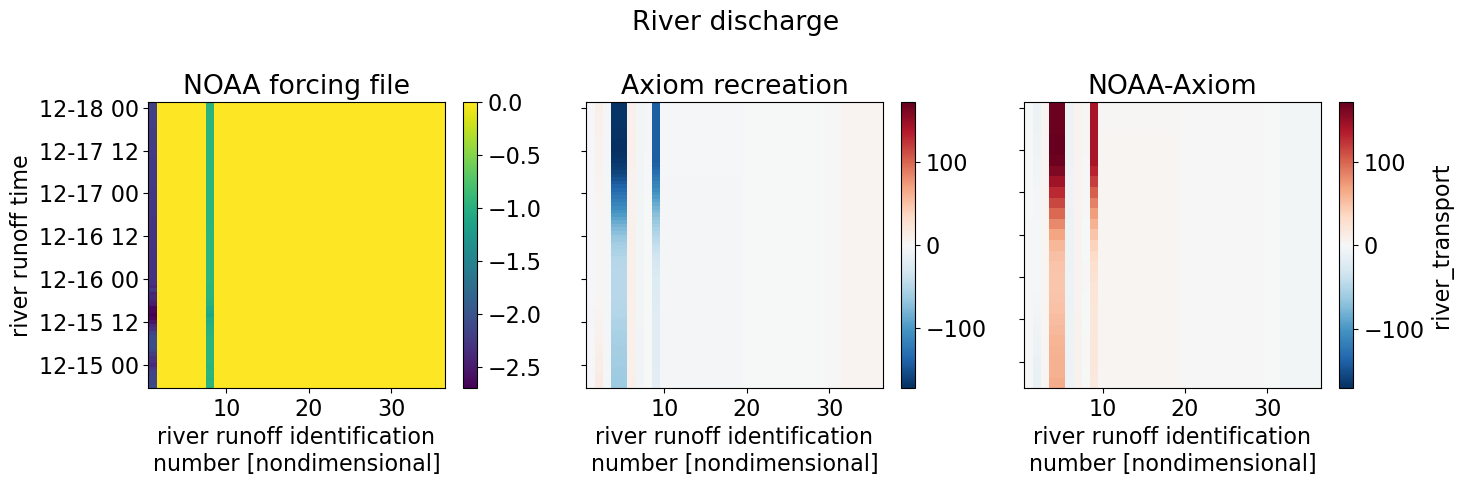

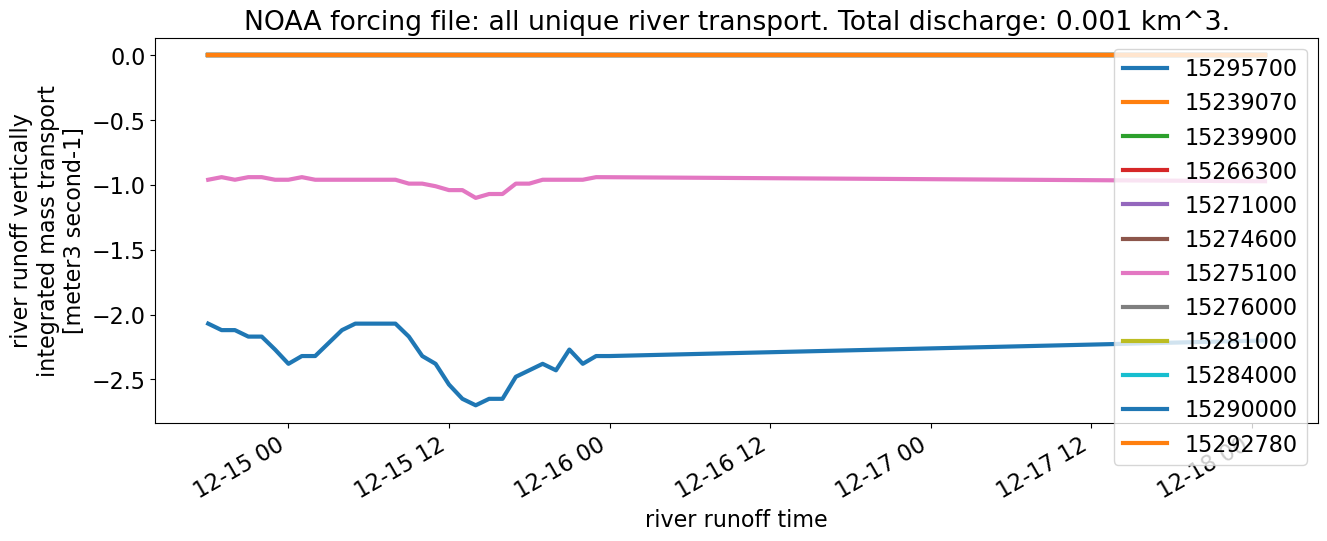

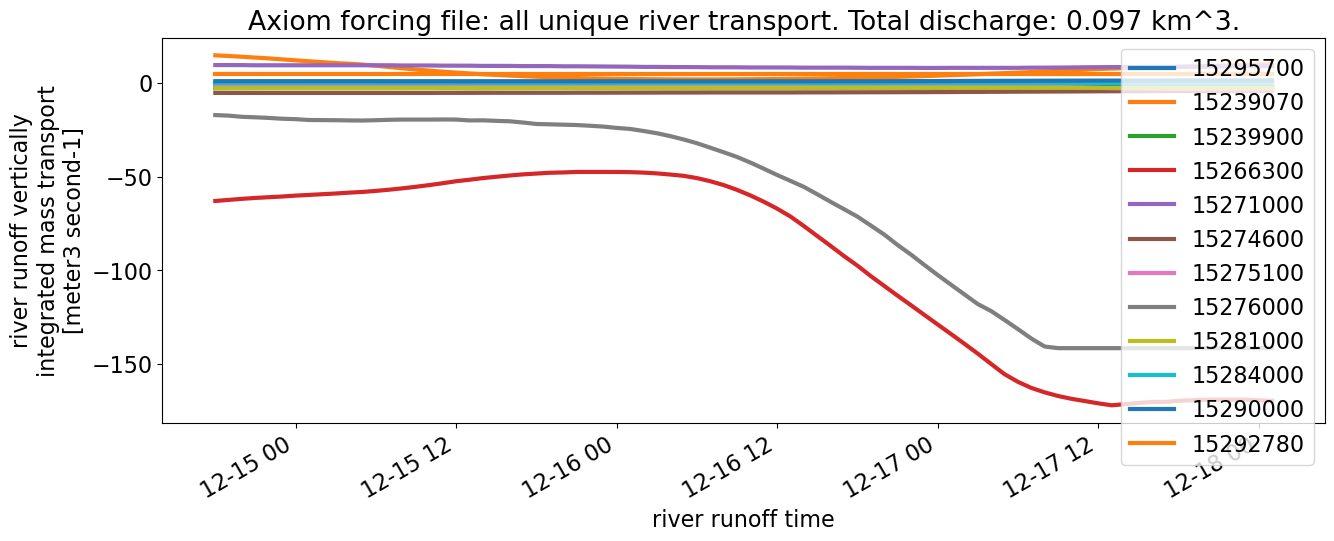

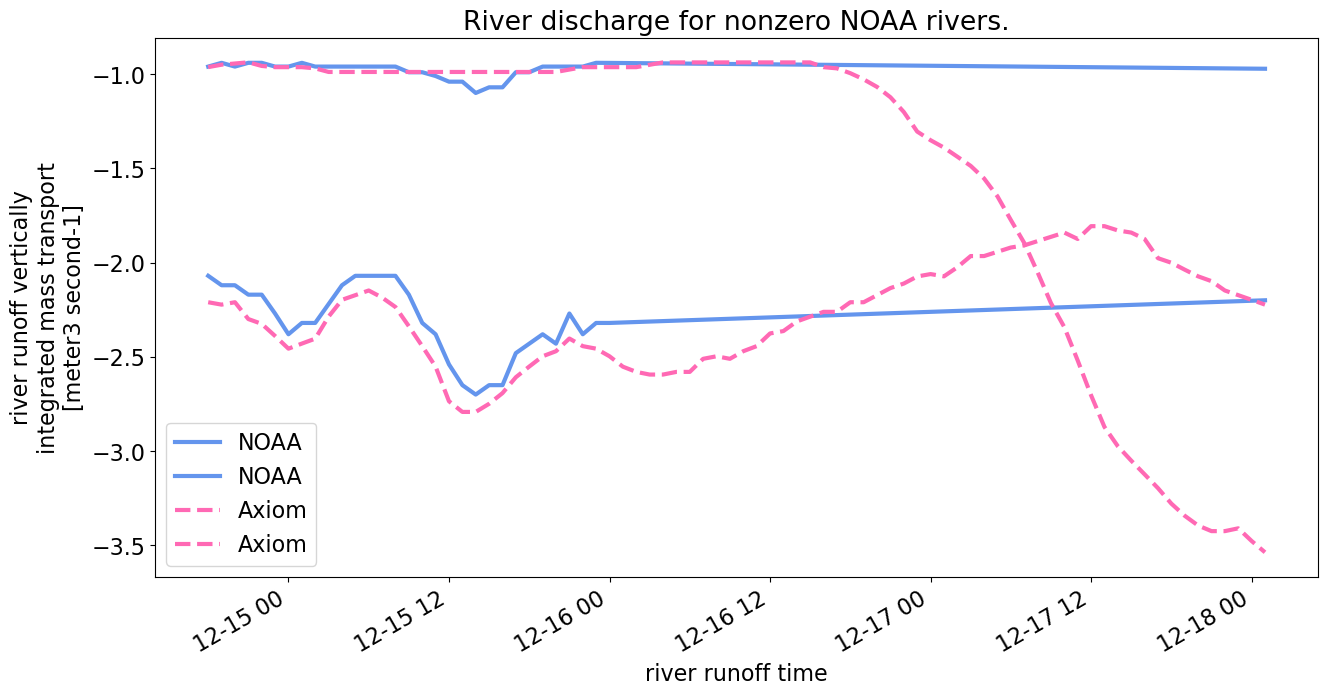

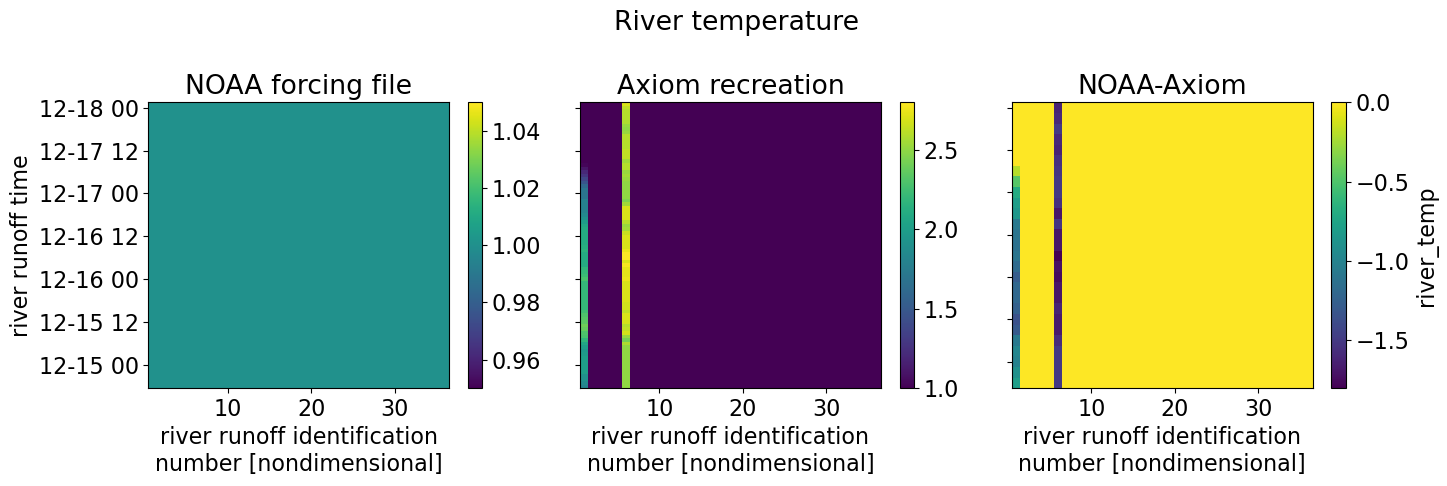

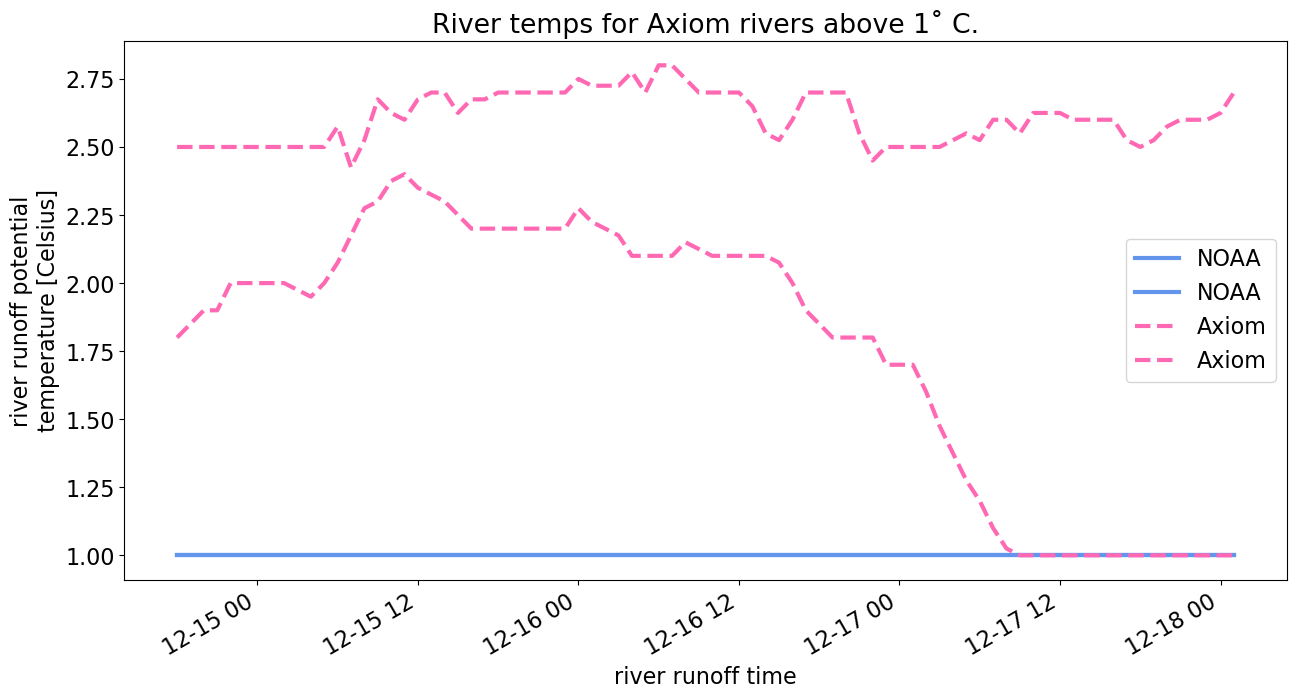

In [10]:
plot_comparison(ds, dscompare)

### January 2023 file

For the same reasons previously listed, the discharge is much higher from the Axiom file: 0.09 km$^3$ compared with 0.001 km$^3$ from the NOAA file. For the rivers that we estimate in the same way as NOAA, we get similar results.

In [11]:
loc = "data/nos.ciofs.river.20230201.t00z.nc"
ds = xr.open_dataset(loc)

start = pd.Timestamp(ds["river_time"].values[0]).strftime("%Y-%m-%dT%H:%MZ")
end = pd.Timestamp(ds["river_time"].values[-1]).strftime("%Y-%m-%dT%H:%MZ")

dscompare = create_river_forcing_file(start, end, ndays=2, window=1)

ds = ds.swap_dims({"time": "river_time"})
dscompare = dscompare.swap_dims({"time": "river_time"})


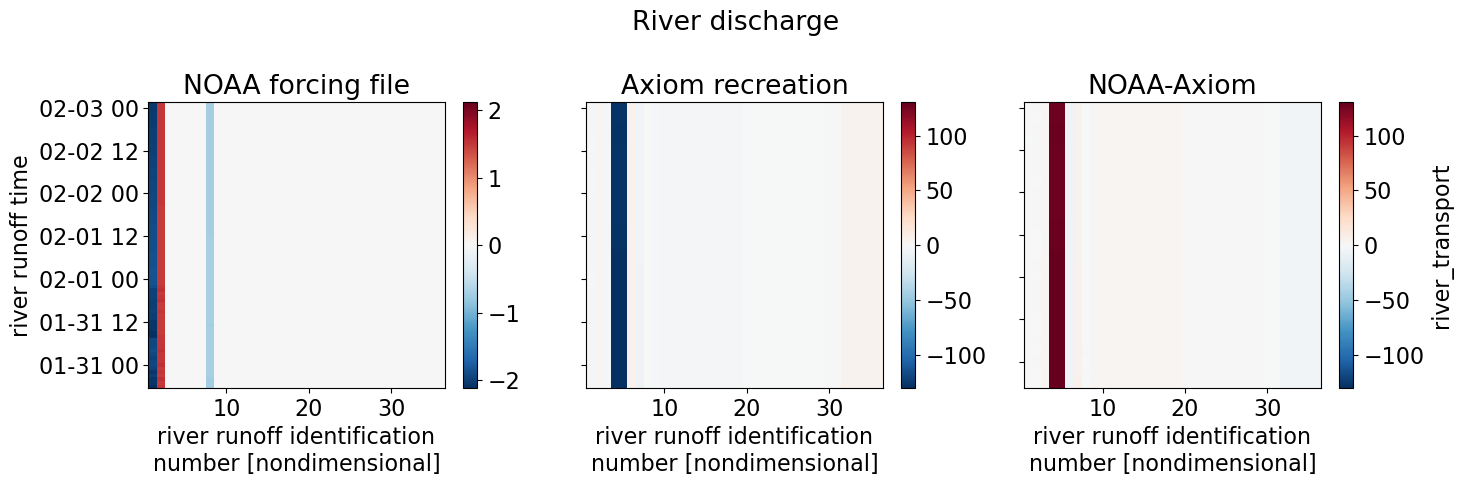

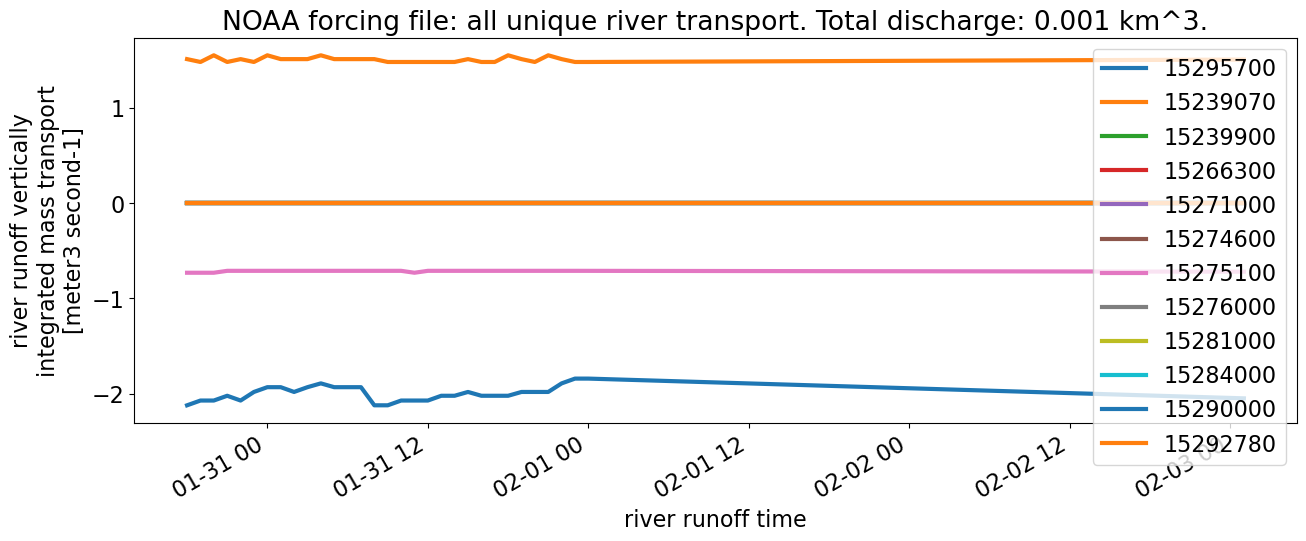

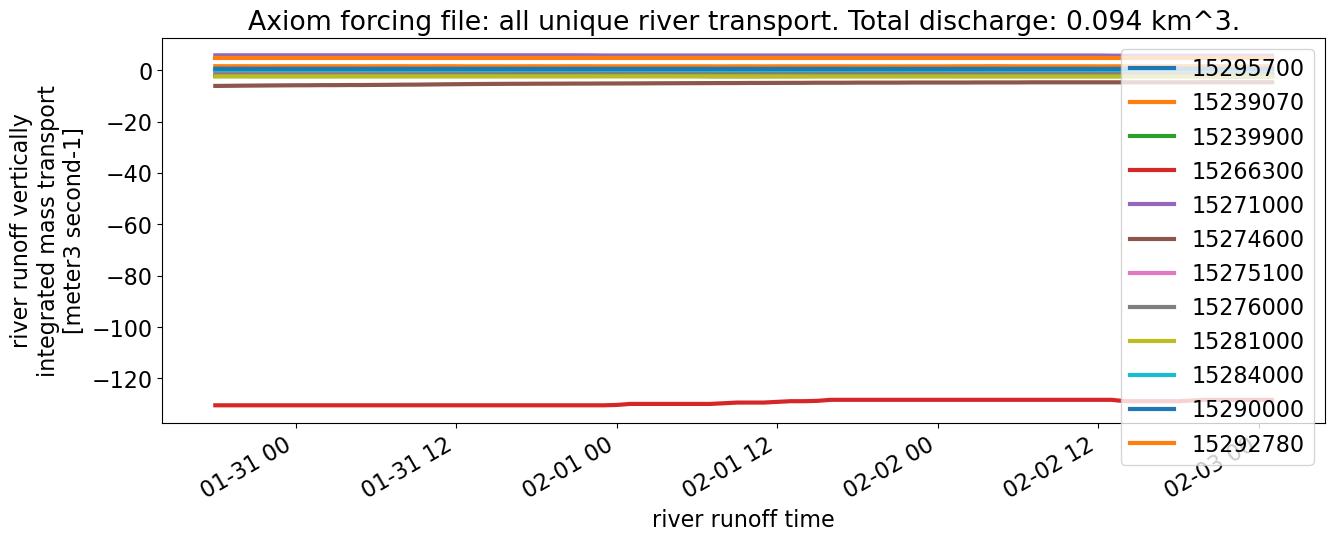

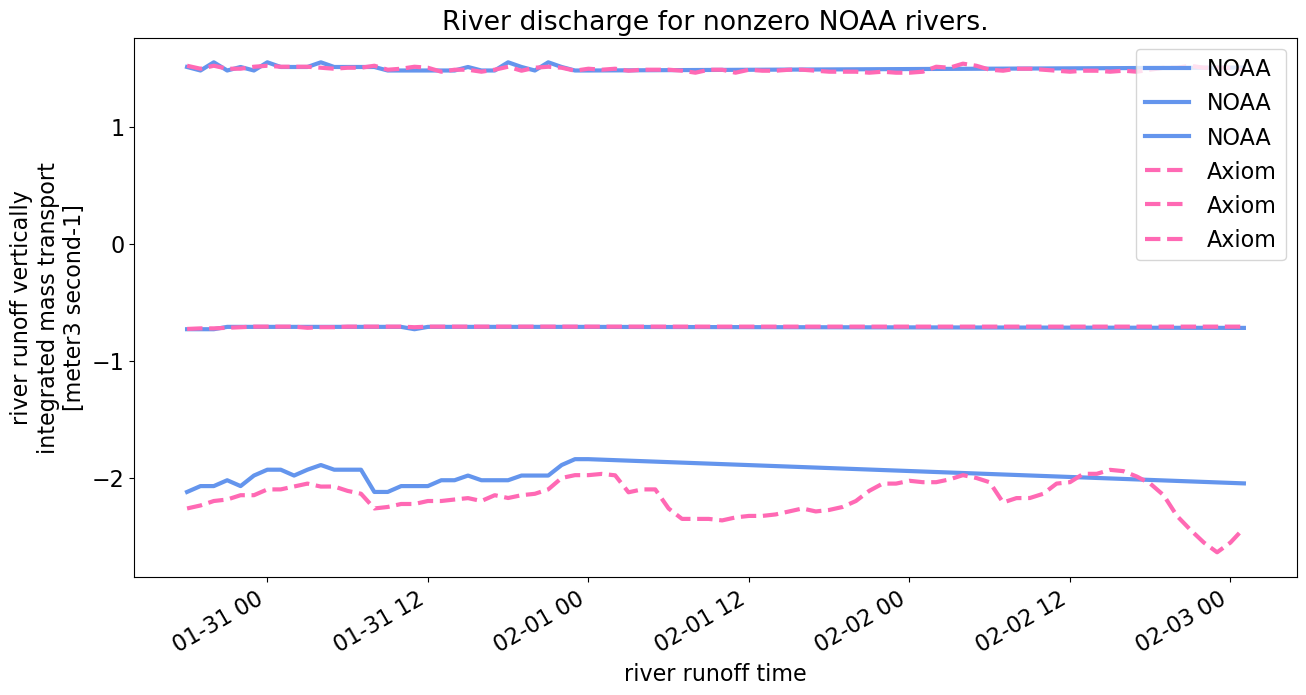

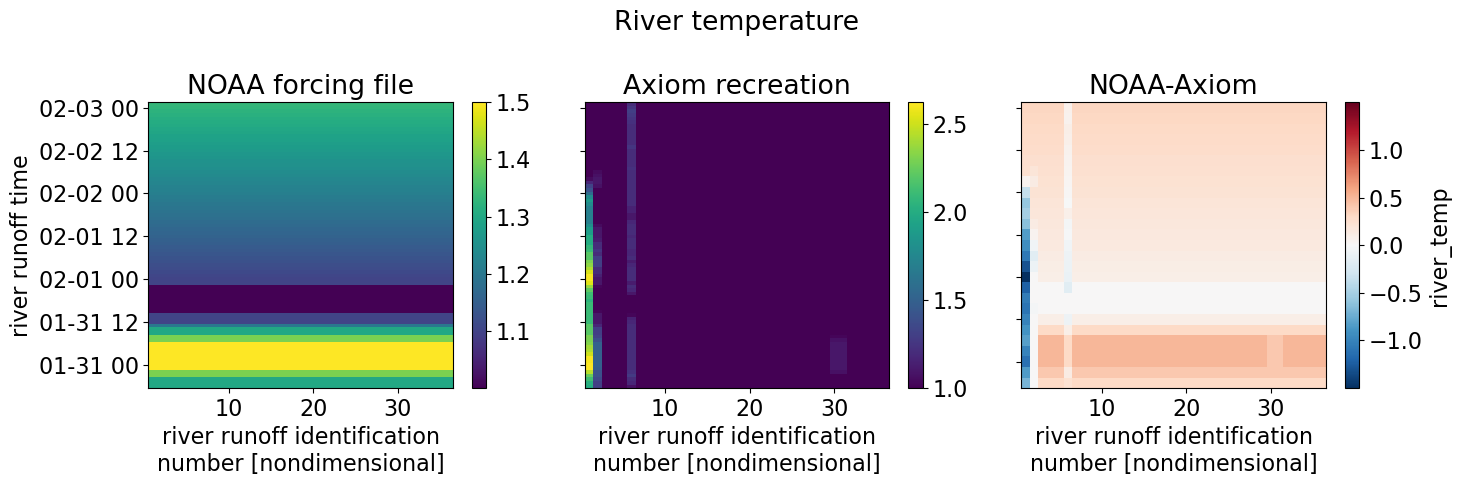

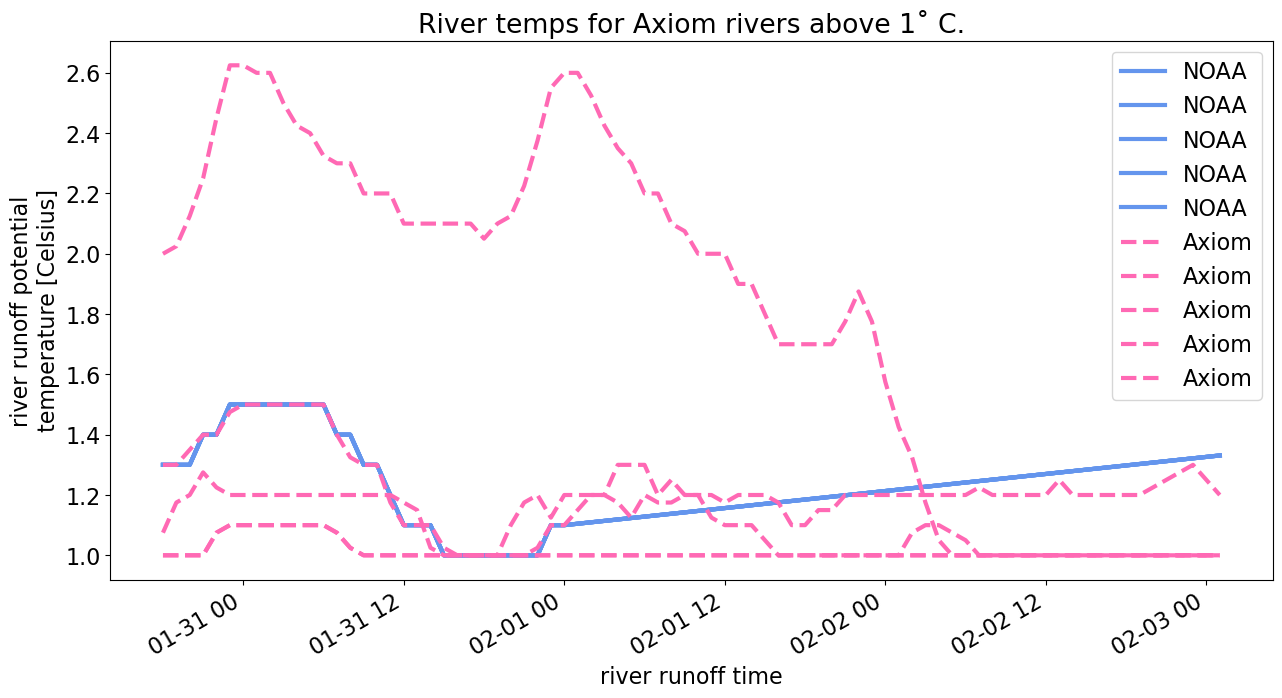

In [12]:
plot_comparison(ds, dscompare)